# Installs

In [60]:
# !pip install numpy==1.19.5
# !pip install pandas==1.3.4
# !pip install statsmodels==0.13.2
# !pip install scikit-learn==1.0.2
# !pip install xgboost==1.6.0
# !pip install catboost==1.0.5
# !pip install deep-forest==0.1.5
# !pip install tensorflow==2.7.0
# !pip install keras-tuner --upgrade
# !pip install shap --upgrade

# Imports

In [61]:
# import onetick.py as otp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from IPython.core.interactiveshell import InteractiveShell

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import STL

from xgboost import XGBRegressor, DMatrix, cv as xgb_cv, callback
from catboost import CatBoostRegressor, Pool, cv as cat_cv, sum_models
from deepforest import CascadeForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import shap

# InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_rows', 200)

# Loading data

## ETF

In [62]:
# db = 'NYSE_TAQ'
# tick_type = 'TRD'
# symbols = ['QQQ']
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db = db, tick_type = tick_type, symbol = symbols, start = start, end = end, identify_input_ts=True)

# data = data.agg({'VOLUME': otp.agg.sum(data['SIZE']),
#                  'TICK_VOLUME': otp.agg.count()},
#                  group_by = ['TICKER'],
#                  bucket_interval = bucket)

# data['hhmm'] = data['Time'].dt.strftime(format='%H:%M')

# etf_df = otp.run(data, apply_times_daily=True, timezone=timezone)

In [63]:
# etf_df = etf_df.groupby(['Time', 'hhmm'], as_index=False)['VOLUME'].sum()
# etf_df = etf_df[(etf_df['Time'].dt.dayofweek!=5) & (etf_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# etf_ts = etf_df.set_index('Time').copy(deep=True)

# etf_ts

In [64]:
# etf_ts.to_csv('./data/etf_nq.csv')

In [65]:
etf_ts = pd.read_csv('../data/etf_nq.csv').set_index('Time')
etf_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,5787283
2021-04-01 09:50:00,09:50,3001767
2021-04-01 10:00:00,10:00,1523707
2021-04-01 10:10:00,10:10,3199697
2021-04-01 10:20:00,10:20,2662730
...,...,...
2022-04-01 15:20:00,15:20,1281702
2022-04-01 15:30:00,15:30,1013253
2022-04-01 15:40:00,15:40,1386788


## Futures

In [66]:
# db = 'CME'
# tick_type = 'TRD'
# symbols = ['NQ\H21', 'NQ\M21', r'NQ\U21', 'NQ\Z21', 'NQ\H22', 'NQ\M22'] #H M U Z
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db = db, tick_type = tick_type, symbol = symbols, start = start, end = end, identify_input_ts=True)
# data['TICKER'] = data['SYMBOL_NAME']
# data = data.agg({'VOLUME': otp.agg.sum(data['SIZE']),
#                  'TICK_VOLUME': otp.agg.count()},
#                  group_by = ['TICKER'],
#                  bucket_interval = bucket)

# data['hhmm'] = data['Time'].dt.strftime(format='%H:%M')

# fut_df = otp.run(data, apply_times_daily=True, timezone=timezone)

In [67]:
# fut_df = fut_df.groupby(['Time', 'hhmm'], as_index=False)['VOLUME'].sum()
# fut_df = fut_df[(fut_df['Time'].dt.dayofweek!=5) & (fut_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# fut_ts = fut_df.set_index('Time').copy(deep=True)

# fut_ts

In [68]:
# fut_ts.to_csv('./data/fut_nq.csv')

In [69]:
fut_ts = pd.read_csv('../data/fut_nq.csv').set_index('Time')
fut_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,31967
2021-04-01 09:50:00,09:50,13194
2021-04-01 10:00:00,10:00,9774
2021-04-01 10:10:00,10:10,26026
2021-04-01 10:20:00,10:20,10889
...,...,...
2022-04-01 15:20:00,15:20,9723
2022-04-01 15:30:00,15:30,9506
2022-04-01 15:40:00,15:40,10394


## Options

In [70]:
# db = 'US_OPTIONS'
# tick_type = 'TRD'
# start = otp.dt(2021, 4, 1)
# end = otp.dt(2022, 4, 1)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db=db, tick_type=tick_type, start=start, end=end, identify_input_ts=True)
# data['Date'] = data['Time'].dt.date()

# volume_date = data.agg({'VOLUME': otp.agg.sum(data['SIZE'])}, group_by=['Date'])
# volume_10min = data.agg({'VOLUME': otp.agg.sum(data['SIZE'])}, bucket_interval = bucket)

# # all_symbols = otp.Symbols(db='US_OPTIONS', date=start, keep_db=True, pattern='QQQ   220302%')
# all_symbols = otp.Symbols(db='US_OPTIONS', start=start, end=end, keep_db=True, pattern='QQQ%')

# symbols_date = otp.funcs.merge([volume_date], symbols=all_symbols, identify_input_ts=True)

# most_traded_by_days = symbols_date.high('VOLUME', n=5, group_by=['Date'])
# most_traded_by_days = otp.run(most_traded_by_days, timezone=timezone)

# symbols = list(pd.unique(most_traded_by_days['SYMBOL_NAME']))
# symbols_10min = otp.funcs.merge([volume_10min], symbols=symbols, identify_input_ts=True)
# symbols_10min['hhmm'] = symbols_10min['Time'].dt.strftime(format='%H:%M')

# symbols_10min['Date'] = symbols_10min['Time'].dt.date()
# symbols_10min = symbols_10min.agg({'VOLUME': otp.agg.sum(symbols_10min['VOLUME'])}, group_by = ['Date', 'hhmm'])

# opt_df = otp.run(symbols_10min, timezone=timezone)
# opt_df

In [71]:
# opt_df['Time'] = pd.to_datetime(opt_df['Date'].astype(str) + ' ' + opt_df['hhmm'])
# opt_df = opt_df[(opt_df['Time'].dt.dayofweek!=5) & (opt_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# opt_ts = opt_df.loc[(opt_df['Time'].dt.time > time(9, 30)) & (opt_df['Time'].dt.time <= time(16, 0))]
# opt_ts = opt_ts.drop('Date', axis=1).set_index('Time').copy(deep=True)
# opt_ts

In [72]:
# opt_ts.to_csv('./data/opt_nq.csv')

In [73]:
opt_ts = pd.read_csv('../data/opt_nq.csv').set_index('Time')
opt_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,20914
2021-04-01 09:50:00,09:50,14998
2021-04-01 10:00:00,10:00,9644
2021-04-01 10:10:00,10:10,17938
2021-04-01 10:20:00,10:20,12092
...,...,...
2022-03-31 15:20:00,15:20,18724
2022-03-31 15:30:00,15:30,12523
2022-03-31 15:40:00,15:40,18835


## Join together

In [74]:
ts = fut_ts.join(etf_ts, lsuffix='_fut', rsuffix='_etf', how='inner')
ts = ts.join(opt_ts, how='inner')
ts = ts.rename(columns={'VOLUME': 'VOLUME_opt'}).drop(['hhmm_fut', 'hhmm_etf'], axis=1)

columns = ['VOLUME_fut', 'VOLUME_etf', 'VOLUME_opt']

test_size = 0.1
val_size = 0.1

val_len = int(ts.shape[0] * val_size + 0.5)
test_len = int(ts.shape[0] * test_size + 0.5)
train_len = int(ts.shape[0] - val_len - test_len + 0.5)

train_indexes = list(range(train_len))
val_indexes = list(range(train_len, train_len + val_len))
test_indexes = list(range(train_len + val_len, train_len + val_len + test_len))

ts_orig = ts.copy(deep=True)[['VOLUME_fut']].rename(columns={'VOLUME_fut': 'VOLUME_fut_orig'})
ts

,VOLUME_fut,VOLUME_etf,hhmm,VOLUME_opt
Time,,,,
2021-04-01 09:40:00,31967,5787283,09:40,20914
2021-04-01 09:50:00,13194,3001767,09:50,14998
2021-04-01 10:00:00,9774,1523707,10:00,9644
2021-04-01 10:10:00,26026,3199697,10:10,17938
2021-04-01 10:20:00,10889,2662730,10:20,12092
...,...,...,...,...
2022-03-31 15:20:00,8872,1283681,15:20,18724
2022-03-31 15:30:00,12924,1501646,15:30,12523
2022-03-31 15:40:00,16582,1970892,15:40,18835


# Data overview

<AxesSubplot:xlabel='Time'>

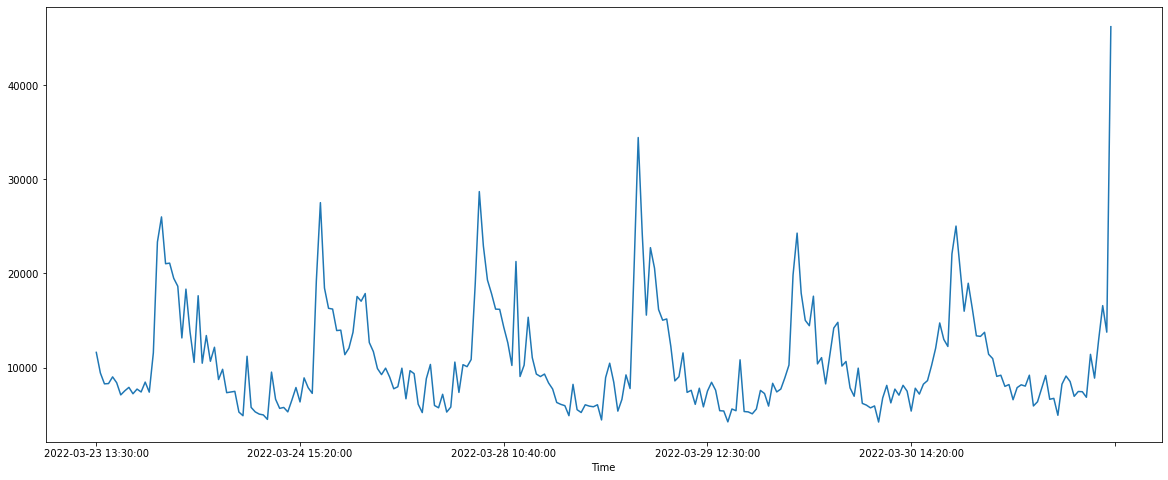

In [75]:
ts['VOLUME_fut'].iloc[-250:].plot(figsize=[20, 8])

## Autocorrelation

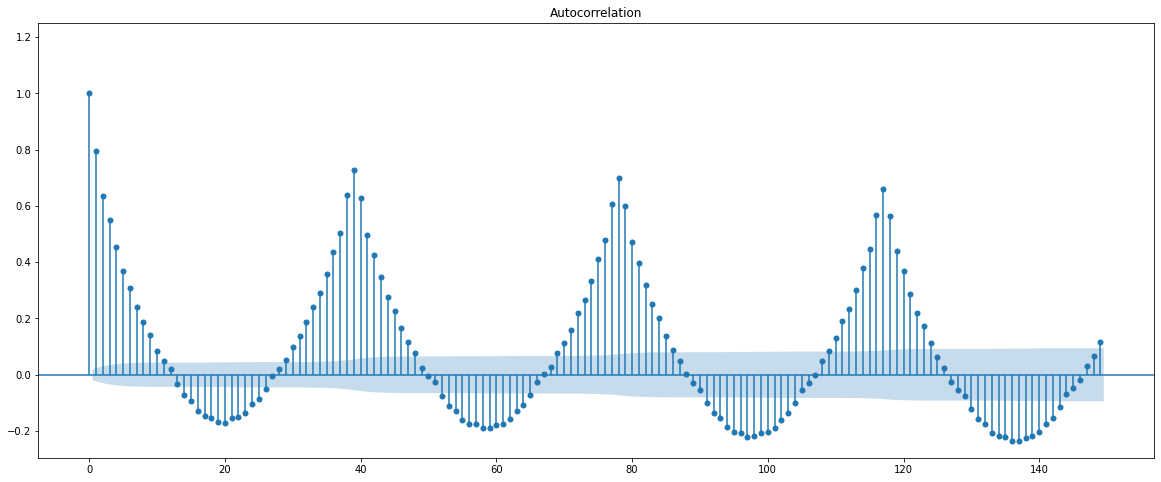

In [76]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(ts['VOLUME_fut'], ax=ax, lags=np.arange(150), auto_ylims=True)

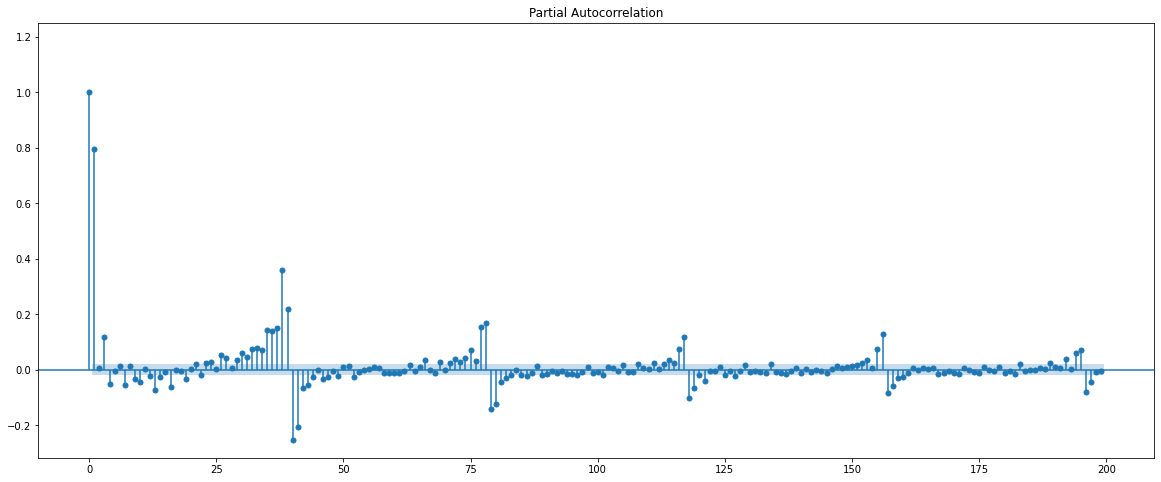

In [77]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_pacf(ts['VOLUME_fut'], ax=ax, lags=np.arange(200), auto_ylims=True, method='ywm')

# Preprocessing

## Cap strong outliers

In [78]:
std_num = 4
for column in columns:
    mean = ts.iloc[train_indexes].mean(numeric_only=True)[column]
    std = ts.iloc[train_indexes].std(numeric_only=True)[column]
    up_border = mean + std_num * std
    down_border = max(0, mean - std_num * std)
    ts[column] = ts[column].where(ts[column] <= up_border, up_border)
    ts[column] = ts[column].where(ts[column] >= down_border, down_border)

## Remove seasonality

### Intraday averaging

In [79]:
bins = 39
window_days = 20
ts[['VOLUME_fut_agg', 'VOLUME_etf_agg', 'VOLUME_opt_agg']] = np.NaN
all_hhmm = pd.unique(ts['hhmm'])

for i in range(0, ts.shape[0] - bins * (window_days + 1) + 1, 39):
    for hhmm in all_hhmm:
        hhmm_df = \
            ts.iloc[i:bins * window_days + i].loc[ts['hhmm'] == hhmm]
        for column in columns:
            vol_agg = hhmm_df.loc[:, column].mean()
            ts.iloc[i + bins * window_days:i + bins * (window_days + 1)].loc[
                ts['hhmm'] == hhmm, f'{column}_agg'] = vol_agg


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


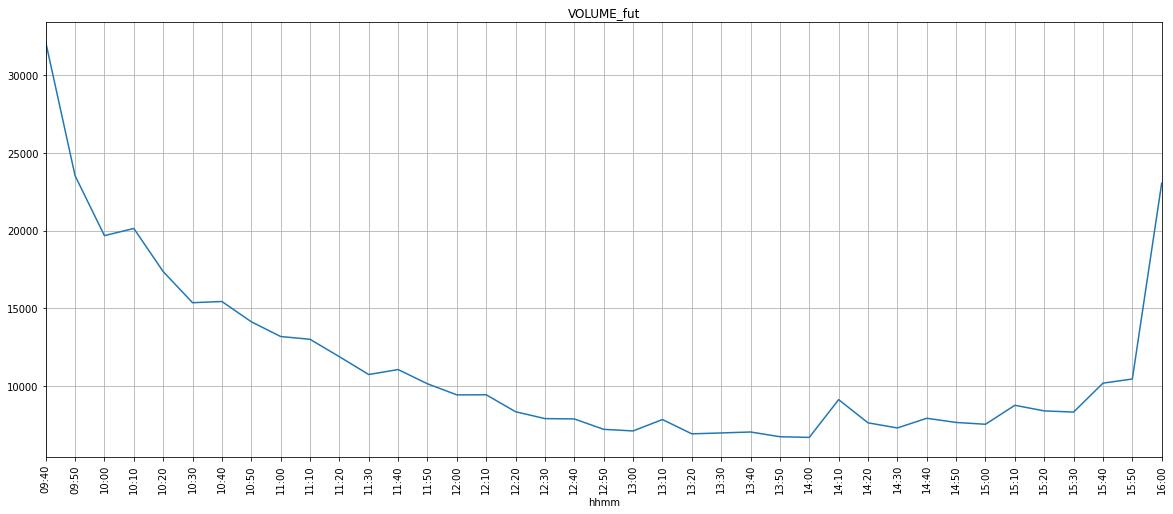

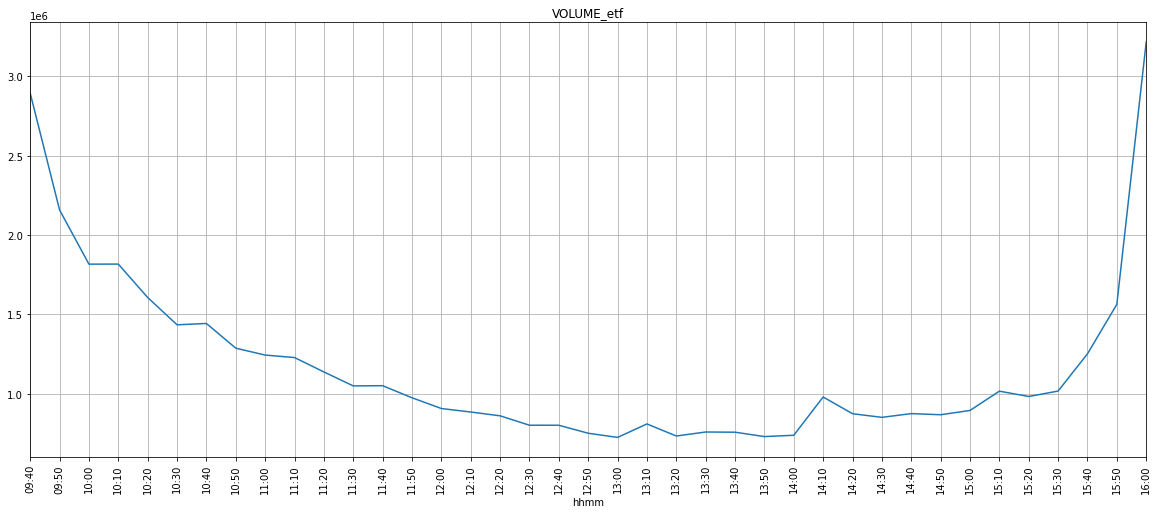

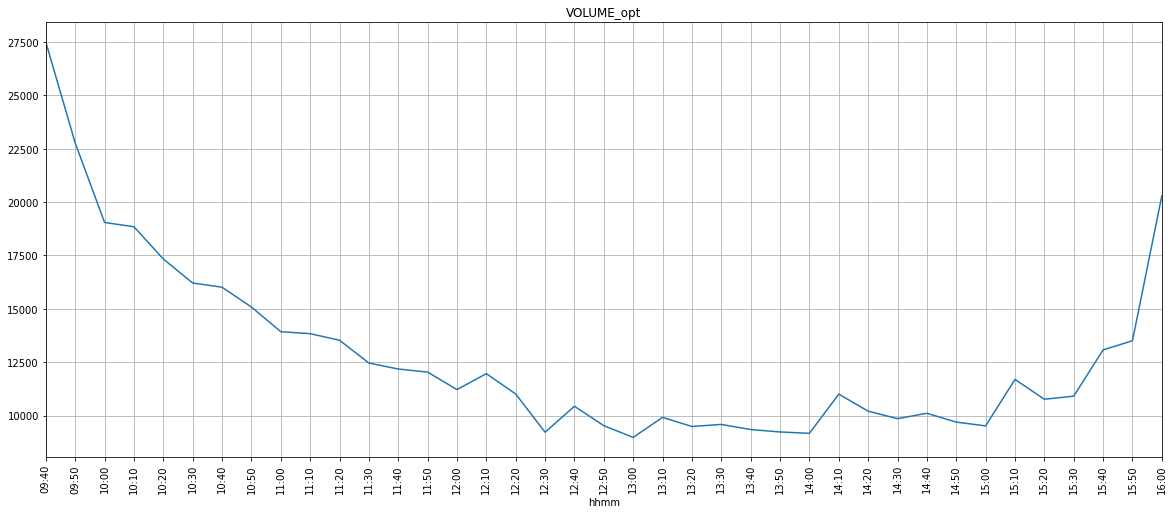

In [80]:
ts_agg = ts.groupby('hhmm').mean()

for column in columns:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax = ts_agg[column].plot(ax=ax, title=column)
    ax.set_xticks(list(range(ts_agg.shape[0])), list(ts_agg.index), rotation='vertical')
    ax.grid()
    ax.set_xlim(0, ts_agg.shape[0] - 1)

### Calculate: VOLUME-INTRADAY_AVERAGE

In [81]:
# ts_unseason = ts.join(ts_agg, on='hhmm', rsuffix='_agg').copy(deep=True)
ts_unseason = ts.copy(deep=True)

for column in columns:
    ts_unseason[column] = ts_unseason[column] - ts_unseason[f'{column}_agg']

ts_unseason.dropna(inplace=True)
ts_unseason = ts_unseason.join(ts_orig)
ts_unseason

,VOLUME_fut,VOLUME_etf,hhmm,VOLUME_opt,VOLUME_fut_agg,VOLUME_etf_agg,VOLUME_opt_agg,VOLUME_fut_orig
Time,,,,,,,,
2021-04-30 09:40:00,-2691.600000,195788.675572,09:40,25493.20,28600.60,2.116289e+06,16699.80,25909
2021-04-30 09:50:00,-1790.650000,-287446.050000,09:50,5996.90,20238.65,1.474934e+06,12514.10,18448
2021-04-30 10:00:00,25.500000,-24788.400000,10:00,2799.75,17406.50,1.288410e+06,12634.25,17432
2021-04-30 10:10:00,-1511.850000,-224423.000000,10:10,4216.80,18005.85,1.283152e+06,13414.20,16494
2021-04-30 10:20:00,-533.400000,-423786.100000,10:20,-3865.65,15143.40,1.182454e+06,11768.65,14610
...,...,...,...,...,...,...,...,...
2022-03-31 15:20:00,-1088.950000,-196412.950000,15:20,5730.90,9960.95,1.480094e+06,12993.10,8872
2022-03-31 15:30:00,3112.500000,-201669.650000,15:30,-2514.45,9811.50,1.703316e+06,15037.45,12924
2022-03-31 15:40:00,5850.400000,129857.300000,15:40,4249.65,10731.60,1.841035e+06,14585.35,16582


<AxesSubplot:xlabel='Time'>

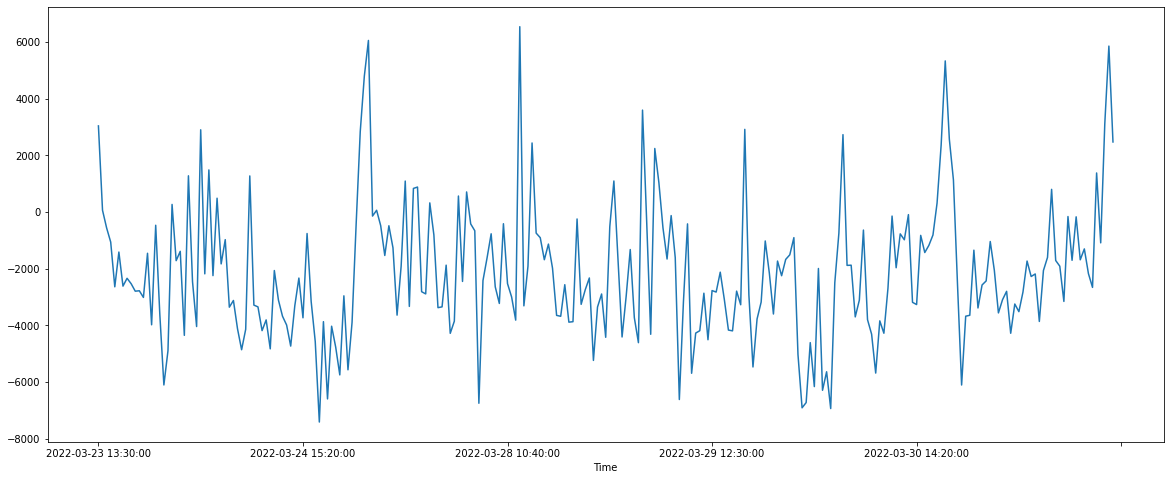

In [82]:
ts_unseason['VOLUME_fut'].iloc[-250:-1].plot(figsize=[20, 8])

# Features

## Partial autocorrelation

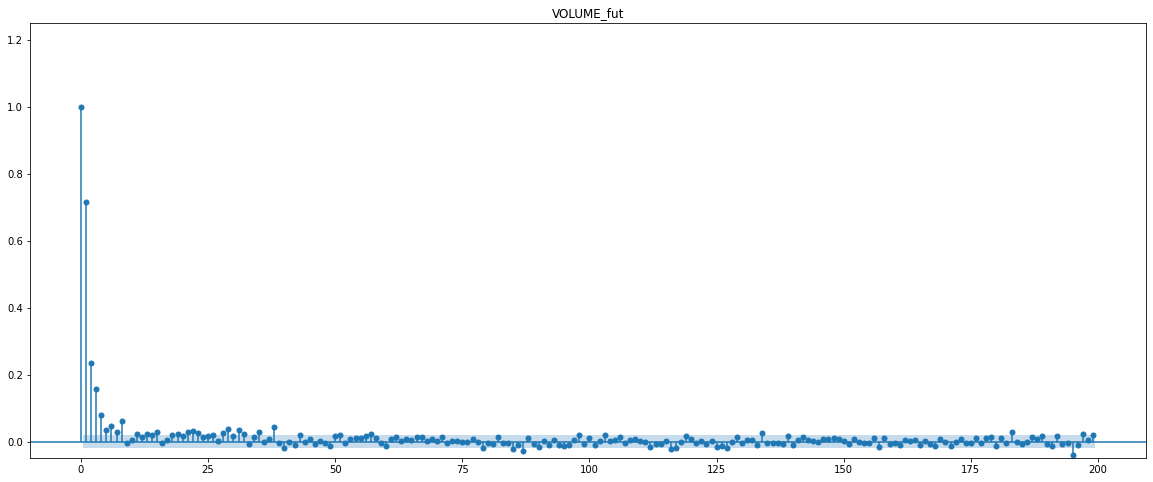

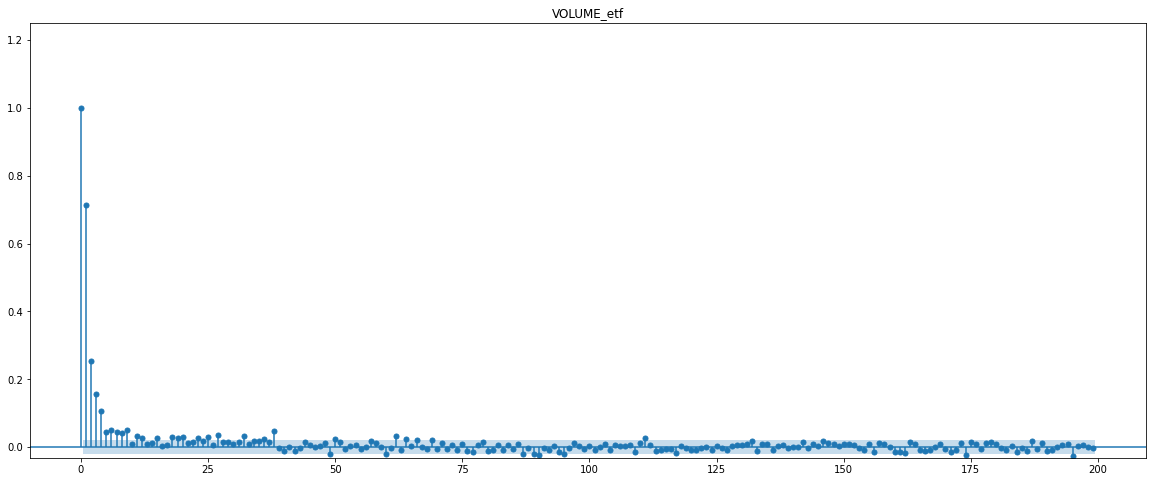

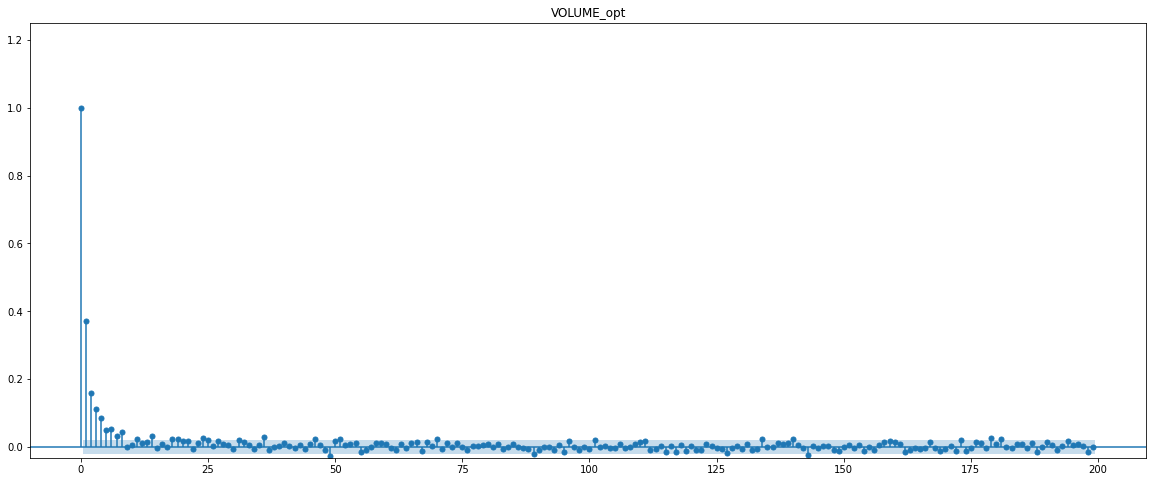

In [83]:
for column in columns:
    fig, ax = plt.subplots(figsize=(20, 8))
    plt_pacf = plot_pacf(ts_unseason[column], ax=ax, lags=np.arange(200), auto_ylims=True, method='ywm', title=column)

## Features

### Add lags

In [84]:
df = ts_unseason[columns + ['hhmm', 'VOLUME_fut_agg', 'VOLUME_fut_orig']].copy(deep=True)[:-1]

periods = [1, 2, 3, 4, 38, 39, 40, 41]
target = ['VOLUME_fut']
features_columns = []
for column in columns:
    for lag in periods:
        feature_col_name = f'{column}_lag_{lag}'
        df[feature_col_name] = df.shift(lag)[column]
        features_columns.append(feature_col_name)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_agg,VOLUME_fut_orig,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,...,VOLUME_etf_lag_40,VOLUME_etf_lag_41,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_40,VOLUME_opt_lag_41
0,-3378.40,-80779.15,-3608.750000,10:00,17789.40,14411,-3237.35,-5451.70,5031.85,5202.90,...,-2.874461e+05,1.957887e+05,-2786.750000,-8997.750000,-5618.350000,21943.700000,4216.800000,2799.750000,5996.900000,25493.200000
1,4221.75,501033.40,-5501.850000,10:10,17529.25,21751,-3378.40,-3237.35,-5451.70,5031.85,...,-2.478840e+04,-2.874461e+05,-3608.750000,-2786.750000,-8997.750000,-5618.350000,-3865.650000,4216.800000,2799.750000,5996.900000
2,-1083.45,-60242.00,-2599.200000,10:20,15329.45,14246,4221.75,-3378.40,-3237.35,-5451.70,...,-2.244230e+05,-2.478840e+04,-5501.850000,-3608.750000,-2786.750000,-8997.750000,1177.724927,-3865.650000,4216.800000,2799.750000
3,131.30,-219040.45,-10104.925073,10:30,13846.70,13978,-1083.45,4221.75,-3378.40,-3237.35,...,-4.237861e+05,-2.244230e+05,-2599.200000,-5501.850000,-3608.750000,-2786.750000,2851.899855,1177.724927,-3865.650000,4216.800000
4,-25.40,-307097.05,-12841.250145,10:40,14661.40,14636,131.30,-1083.45,4221.75,-3378.40,...,-1.764490e+04,-4.237861e+05,-10104.925073,-2599.200000,-5501.850000,-3608.750000,1672.550000,2851.899855,1177.724927,-3865.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,1376.00,440060.85,8258.524927,15:10,10024.00,11400,-2659.70,-2173.05,-1302.50,-1686.25,...,-1.573346e+05,4.880598e+05,-327.650000,-5178.600000,-4610.100000,-7723.550000,8431.950000,46693.801455,6107.400000,2520.700000
9041,-1088.95,-196412.95,5730.900000,15:20,9960.95,8872,1376.00,-2659.70,-2173.05,-1302.50,...,1.718117e+06,-1.573346e+05,8258.524927,-327.650000,-5178.600000,-4610.100000,-1068.900000,8431.950000,46693.801455,6107.400000
9042,3112.50,-201669.65,-2514.450000,15:30,9811.50,12924,-1088.95,1376.00,-2659.70,-2173.05,...,6.314944e+05,1.718117e+06,5730.900000,8258.524927,-327.650000,-5178.600000,-4642.150000,-1068.900000,8431.950000,46693.801455
9043,5850.40,129857.30,4249.650000,15:40,10731.60,16582,3112.50,-1088.95,1376.00,-2659.70,...,9.020248e+05,6.314944e+05,-2514.450000,5730.900000,8258.524927,-327.650000,66.400000,-4642.150000,-1068.900000,8431.950000


### Features importance

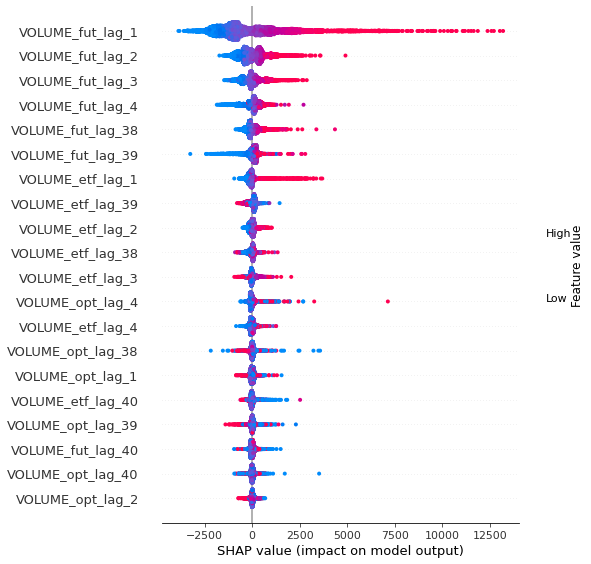

Index(['VOLUME_fut_lag_1', 'VOLUME_fut_lag_2', 'VOLUME_fut_lag_3',
       'VOLUME_fut_lag_4', 'VOLUME_fut_lag_38', 'VOLUME_fut_lag_39',
       'VOLUME_etf_lag_1', 'VOLUME_etf_lag_39', 'VOLUME_etf_lag_2',
       'VOLUME_etf_lag_38'],
      dtype='object')

In [85]:
cat = CatBoostRegressor(iterations=550)
cat.fit(df.loc[train_indexes][features_columns],
        df.loc[train_indexes][target],
        verbose=0,
        plot=False)
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(df.loc[train_indexes][features_columns])
shap.summary_plot(shap_values, df.loc[train_indexes][features_columns])

top_features = pd.DataFrame(shap_values, columns=df[features_columns].columns).apply(
    lambda x: abs(x)).sum().sort_values(ascending=False)[:10].index
top_features

# Splitting

In [86]:
val_size /= (1 - test_size)
x_train, x_test, y_train, y_test = train_test_split(df[top_features], df[target], test_size=test_size, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, shuffle=False)

In [87]:
x_train

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_etf_lag_1,VOLUME_etf_lag_39,VOLUME_etf_lag_2,VOLUME_etf_lag_38
0,-3237.35,-5451.70,5031.85,5202.90,-1511.85,25.50,-2.505441e+05,-2.478840e+04,4.758520e+04,-2.244230e+05
1,-3378.40,-3237.35,-5451.70,5031.85,-533.40,-1511.85,-8.077915e+04,-2.244230e+05,-2.505441e+05,-4.237861e+05
2,4221.75,-3378.40,-3237.35,-5451.70,2151.15,-533.40,5.010334e+05,-4.237861e+05,-8.077915e+04,-1.764490e+04
3,-1083.45,4221.75,-3378.40,-3237.35,6489.15,2151.15,-6.024200e+04,-1.764490e+04,5.010334e+05,2.607989e+05
4,131.30,-1083.45,4221.75,-3378.40,-159.10,6489.15,-2.190404e+05,2.607989e+05,-6.024200e+04,-4.652782e+05
...,...,...,...,...,...,...,...,...,...,...
7230,4721.05,3752.20,4742.75,79.40,8733.15,16533.35,2.002198e+06,3.318223e+06,1.138331e+06,2.812079e+06
7231,2310.05,4721.05,3752.20,4742.75,13732.75,8733.15,6.465667e+05,2.812079e+06,2.002198e+06,3.496720e+06
7232,1030.80,2310.05,4721.05,3752.20,17089.80,13732.75,3.306854e+05,3.496720e+06,6.465667e+05,3.454153e+06
7233,1381.40,1030.80,2310.05,4721.05,13015.90,17089.80,5.085233e+05,3.454153e+06,3.306854e+05,2.783242e+06


In [88]:
y_train

,VOLUME_fut
0,-3378.40
1,4221.75
2,-1083.45
3,131.30
4,-25.40
...,...
7230,2310.05
7231,1030.80
7232,1381.40
7233,1985.60


In [89]:
x_train.index, x_val.index, x_test.index

(Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234],
            dtype='int64', length=7235),
 Int64Index([7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244,
             ...
             8130, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8139],
            dtype='int64', length=905),
 Int64Index([8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149,
             ...
             9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044],
            dtype='int64', length=905))

# Scaling

In [90]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = pd.DataFrame(data=scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_val = pd.DataFrame(data=scaler.transform(x_val), index=x_val.index, columns=x_val.columns)
x_test = pd.DataFrame(data=scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

In [91]:
x_train

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_etf_lag_1,VOLUME_etf_lag_39,VOLUME_etf_lag_2,VOLUME_etf_lag_38
0,0.333103,0.293767,0.479998,0.483037,0.363755,0.391065,0.377965,0.412427,0.423475,0.381953
1,0.330597,0.333103,0.293767,0.479998,0.381136,0.363755,0.403880,0.381953,0.377965,0.351520
2,0.465608,0.330597,0.333103,0.293767,0.428825,0.381136,0.492694,0.351520,0.403880,0.413517
3,0.371365,0.465608,0.330597,0.333103,0.505886,0.428825,0.407015,0.413517,0.492694,0.456022
4,0.392944,0.371365,0.465608,0.330597,0.387786,0.505886,0.382774,0.456022,0.407015,0.345186
...,...,...,...,...,...,...,...,...,...,...
7230,0.474477,0.457267,0.474863,0.392022,0.545749,0.684313,0.721848,0.922741,0.589978,0.845477
7231,0.431648,0.474477,0.457267,0.474863,0.634563,0.545749,0.514910,0.845477,0.721848,0.949989
7232,0.408923,0.431648,0.474477,0.457267,0.694198,0.634563,0.466690,0.949989,0.514910,0.943491
7233,0.415151,0.408923,0.431648,0.474477,0.621829,0.694198,0.493837,0.943491,0.466690,0.841075


# Training - Prediction

## Baseline model (current value = previous value)

In [92]:
tdf = df[['VOLUME_fut', 'VOLUME_fut_orig', 'VOLUME_fut_agg']].copy(deep=True)
tdf['prediction'] = tdf['VOLUME_fut'].shift(1)
tdf.dropna(inplace=True)
tdf_test = tdf.loc[x_test.index]

tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_orig']

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_baseline = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_baseline = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_baseline = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
print(std_orig)
print('MAE/StdDev', mae_baseline / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_baseline, mae_baseline, mape_baseline)

6600.084394958816
MAE/StdDev 38.15032901866229
R2, MAE, MAPE:
0.693874749196424 2517.9539121861744 0.21110923894757902


## XGBoost

In [93]:
# xgb = XGBRegressor(nthread=4, n_estimators=300, max_depth=1, min_child_weight=6, learning_rate=0.08)
# xgb.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=0)

class SaveBestModel(callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters

    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model


param_grid = {'max_depth': [1], 'min_child_weight': [1], 'learning_rate': [0.09],
              'models_num': [10], 'early_stopping_rounds': [30]}

for params in ParameterGrid(param_grid):

    tscv = TimeSeriesSplit(n_splits=params['models_num'])
    cv_index_list = []
    for cv_train_index, cv_val_index in tscv.split(pd.concat([x_train, x_val])):
        cv_index_list.append((cv_train_index, cv_val_index))

    cv_models = []
    xgb_params = {
        # 'nthread': 4,
        # 'n_estimators': 500,
        'max_depth': params['max_depth'],
        'min_child_weight': params['min_child_weight'],
        'learning_rate': params['learning_rate']}

    data_dmatrix = DMatrix(data=pd.concat([x_train, x_val]), label=pd.concat([y_train, y_val]))

    cv_results = xgb_cv(dtrain=data_dmatrix, params=xgb_params, folds=cv_index_list, num_boost_round=500,
                        early_stopping_rounds=params['early_stopping_rounds'], metrics="mae", as_pandas=True,
                        seed=0, shuffle=False, callbacks=[SaveBestModel(cv_models)])
    print(params)
    print(cv_results['test-mae-mean'].min())

{'early_stopping_rounds': 30, 'learning_rate': 0.09, 'max_depth': 1, 'min_child_weight': 1, 'models_num': 10}
2109.810559


MAE/StdDev 32.81498439894433
R2, MAE, MAPE:
0.7701811332770669 2165.816664522895 0.18454368804959367


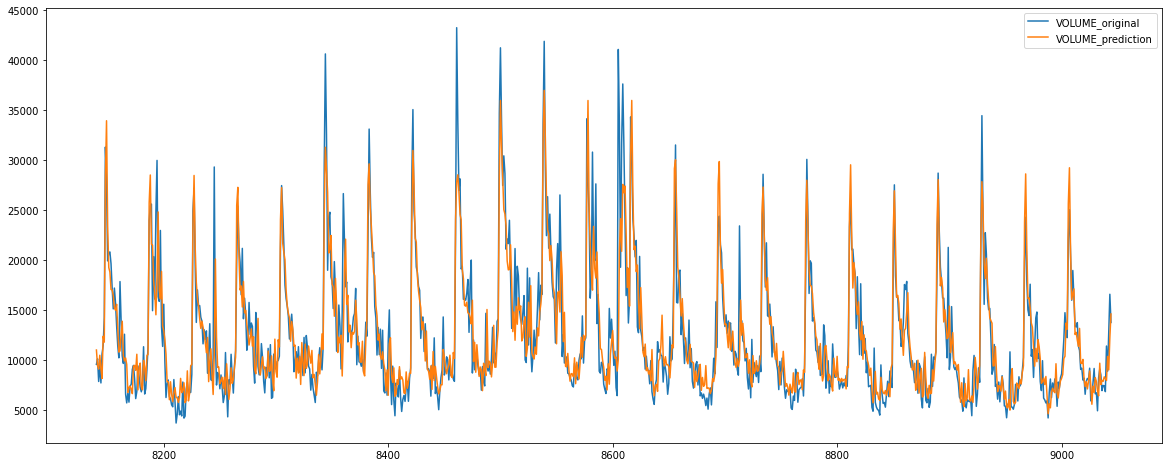

In [94]:
# prediction_xgb = pd.DataFrame(xgb.predict(x_test), index=x_test.index, columns=['prediction'])

prediction_xgb = pd.DataFrame(
    pd.concat([pd.DataFrame(xgb.predict(DMatrix(x_test)), index=x_test.index) for xgb in cv_models],
              axis=1).mean(axis=1), columns=['prediction'])

tdf_test = prediction_xgb.join(df)[['prediction', 'VOLUME_fut_agg', 'VOLUME_fut_orig']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_orig']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_xgb = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_xgb = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_xgb = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_xgb / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_xgb, mae_xgb, mape_xgb)

<AxesSubplot:>

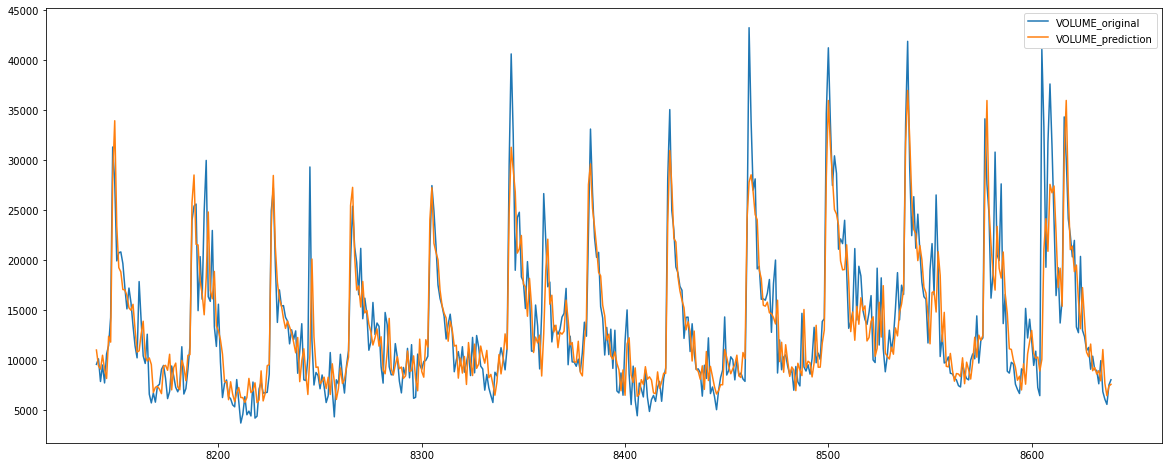

In [95]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

## CatBoost

In [96]:
# cat = CatBoostRegressor(learning_rate=0.08, depth=4, l2_leaf_reg=1, iterations=1000)
# cat.fit(x_train, y_train, eval_set=(x_val, y_val), use_best_model=True, verbose=0, plot=True)

param_grid = {'depth': [2], 'l2_leaf_reg': [3], 'learning_rate': [0.09], 'models_num': [10],
              'early_stopping_rounds': [30]}
for params in ParameterGrid(param_grid):
    models_num = params['models_num']
    cv_dataset = Pool(data=pd.concat([x_train, x_val]), label=pd.concat([y_train, y_val]))

    cat_params = {"iterations": 500,
                  "depth": params['depth'],
                  "l2_leaf_reg": params['l2_leaf_reg'],
                  "learning_rate": params['learning_rate'],
                  "loss_function": "MAE",
                  "custom_metric": 'R2',
                  # "eval_metric": 'BalancedAccuracy',
                  "use_best_model": True,
                  "verbose": False}

    res = cat_cv(cv_dataset,
                 cat_params,
                 fold_count=models_num,
                 shuffle=False,
                 early_stopping_rounds=params['early_stopping_rounds'],
                 type='TimeSeries',
                 return_models=True,
                 plot=False,
                 logging_level='Silent')
    print(params)
    print(res[0]['test-MAE-mean'].min())

{'depth': 2, 'early_stopping_rounds': 30, 'l2_leaf_reg': 3, 'learning_rate': 0.09, 'models_num': 10}
2070.4200120468267


MAE/StdDev 32.247811018681965
R2, MAE, MAPE:
0.7609025722783413 2128.382742759838 0.17338454665249972


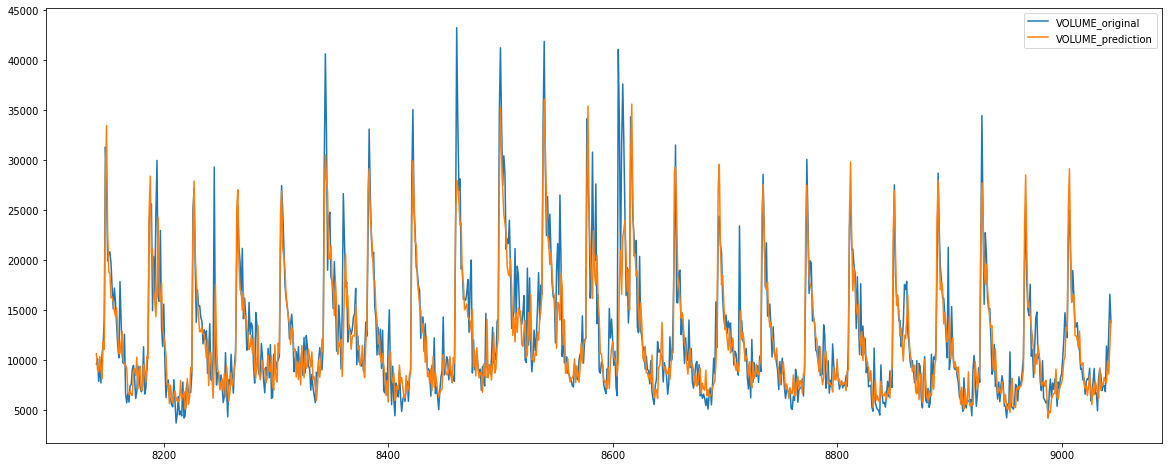

In [97]:
cat = sum_models(res[1], [1 / models_num] * models_num)

prediction_cat = pd.DataFrame(cat.predict(x_test), index=x_test.index, columns=['prediction'])

tdf_test = prediction_cat.join(df)[['prediction', 'VOLUME_fut_agg', 'VOLUME_fut_orig']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_orig']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_cat = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_cat = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_cat = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_cat / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_cat, mae_cat, mape_cat)

<AxesSubplot:>

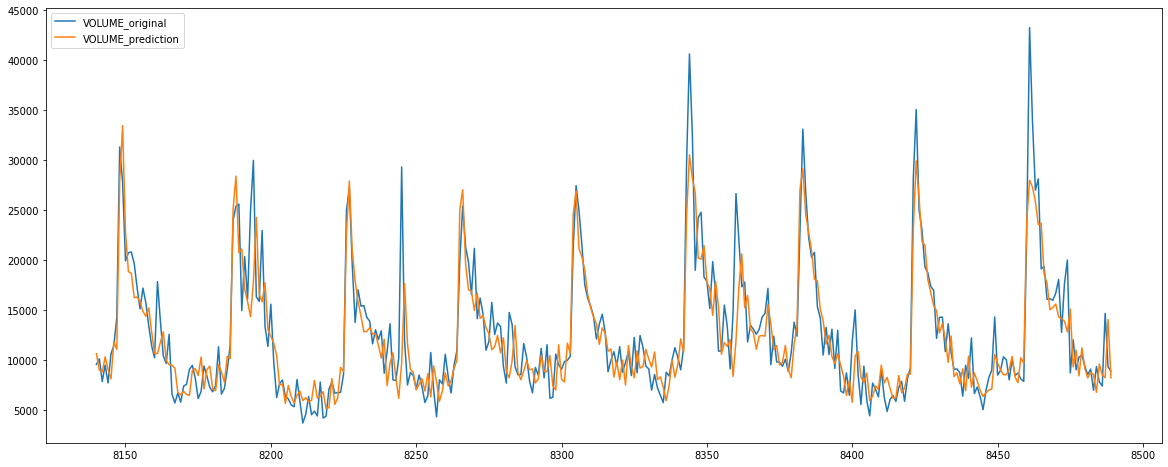

In [98]:
tdf_test.iloc[:350]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:350]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

## DNN

In [99]:
class TSCVTuner(kt.engine.tuner.Tuner):
    def on_search_begin(self):
        super().on_search_begin()
        self.results = {}
        self.results['trials'] = []
        self.results['models'] = []
        self.results['metrics'] = []
        self.results['params'] = []

    def run_trial(self, trial, x, y, **kwargs):
        hp = trial.hyperparameters
        tscv = TimeSeriesSplit(5)
        val_losses = []
        for train_indices, test_indices in tscv.split(x):
            x_train_cv, x_test_cv = x.loc[train_indices], x.loc[test_indices]
            y_train_cv, y_test_cv = y.loc[train_indices], y.loc[test_indices]
            model = self.hypermodel.build(hp)
            history = model.fit(x_train_cv, y_train_cv, validation_data=(x_test_cv, y_test_cv), **kwargs)
            metric = model.evaluate(x_test_cv, y_test_cv, verbose=0)
            val_losses.append(metric)
            self.save_model(trial.trial_id, model, metric, str(hp.get_config()['values']))

        print(hp.get_config()['values'], 'metric value:', np.mean(val_losses))
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})

        return {'val_loss': np.mean(val_losses)}

    def save_model(self, trial_id, model, metric, params, step=0):
        # if params not in self.results.keys():
        #     self.results[params] = {}
        #     self.results[params]['models'] = []
        #     self.results[params]['metrics'] = []
        # self.results[params]['models'].append(model)
        # self.results[params]['metrics'].append(metric)
        self.results['trials'].append(trial_id)
        self.results['models'].append(model)
        self.results['metrics'].append(metric)
        self.results['params'].append(params)


class DNN(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Choice('units1', [28, 32]), activation=hp.Choice('activation1', ['relu'])))
        # model.add(Dropout(hp.Choice('drop1', [0.0, 0.1, 0.5])))
        model.add(Dense(units=hp.Choice('units2', [28, 32]), activation=hp.Choice('activation2', ['relu'])))
        # model.add(Dropout(hp.Choice('drop2', [0.0, 0.1, 0.5])))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='RMSprop')
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            epochs=hp.Choice('epochs', [1024]),
            batch_size=hp.Choice('batch_size', [32]),
            shuffle=False,
            verbose=0,
            **kwargs
        )


tuner = TSCVTuner(
    oracle=kt.oracles.RandomSearch(
        objective='val_loss',
        max_trials=10),
    hypermodel=DNN(),
    directory='./dnn_checkpoints/',
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
tuner.search(pd.concat([x_train, x_val]), pd.concat([y_train, y_val]), batch_size=32, epochs=1024, shuffle=False,
             verbose=0, callbacks=[early_stopping])

{'units1': 32, 'activation1': 'relu', 'units2': 32, 'activation2': 'relu'} metric value: 10931946.7
{'units1': 32, 'activation1': 'relu', 'units2': 28, 'activation2': 'relu'} metric value: 10772381.5
{'units1': 28, 'activation1': 'relu', 'units2': 28, 'activation2': 'relu'} metric value: 10932148.9
{'units1': 28, 'activation1': 'relu', 'units2': 32, 'activation2': 'relu'} metric value: 10886320.9
INFO:tensorflow:Oracle triggered exit


In [100]:
min_index = pd.DataFrame(tuner.results).groupby(['trials']).mean().idxmin()
dnn_models = pd.DataFrame(tuner.results).set_index('trials').loc[min_index['metrics']]['models'].values

In [101]:
# # to-do: combine tuning with cross validation
# class DNN(kt.HyperModel):
#     def build(self, hp):
#         from tensorflow.keras.models import Sequential
#         from tensorflow.keras.layers import Dense, Dropout
#
#         model = Sequential()
#         model.add(Dense(units=hp.Choice('units1', [24, 28, 32]), activation = hp.Choice('activation1', ['relu'])))
#         # model.add(Dropout(hp.Choice('drop1', [0.0, 0.1, 0.5])))
#         model.add(Dense(units=hp.Choice('units2', [12, 16, 20, 24, 28, 32]), activation = hp.Choice('activation2', ['relu'])))
#         # model.add(Dropout(hp.Choice('drop2', [0.0, 0.1, 0.5])))
#         model.add(Dense(1))
#
#         model.compile(loss = 'mean_squared_error', optimizer = 'RMSprop')
#         return model
#
#     def fit(self, hp, model, *args, **kwargs):
#         return model.fit(
#             *args,
#             epochs=hp.Choice('epochs', [1024]),
#             batch_size=hp.Choice('batch_size', [32]),
#             shuffle=False,
#             verbose=0,
#             **kwargs
#         )
#
# tuner = kt.RandomSearch(
#     DNN(),
#     objective='val_loss',
#     max_trials = 18,
#     directory='./dnn_checkpoints/',
#     overwrite=True,
# )
# early_stopping = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
# tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping])

In [102]:
# tuner.results_summary()

In [103]:
# mae_dnn = []
# for i in range(1,11):
#     dnn_models = tuner.get_best_models(num_models=i)
#
#     prediction_dnn = pd.DataFrame(pd.concat([pd.DataFrame(dnn.predict(x_val), index=x_val.index) for dnn in dnn_models], axis=1).mean(axis=1), columns=['prediction'])
#
#     tdf_val = prediction_dnn.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
#     tdf_val['VOLUME_prediction'] = tdf_val['prediction'] + tdf_val['VOLUME_fut_agg']
#     tdf_val['VOLUME_original'] = tdf_val['VOLUME_fut'] + tdf_val['VOLUME_fut_agg']
#
#     mae_dnn.append(mean_absolute_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction']))
# dnn_models = tuner.get_best_models(num_models=np.argmin(mae_dnn)+1)

MAE/StdDev 33.45214502181436
R2, MAE, MAPE:
0.7661083822240289 2207.869803363762 0.19379979414581647


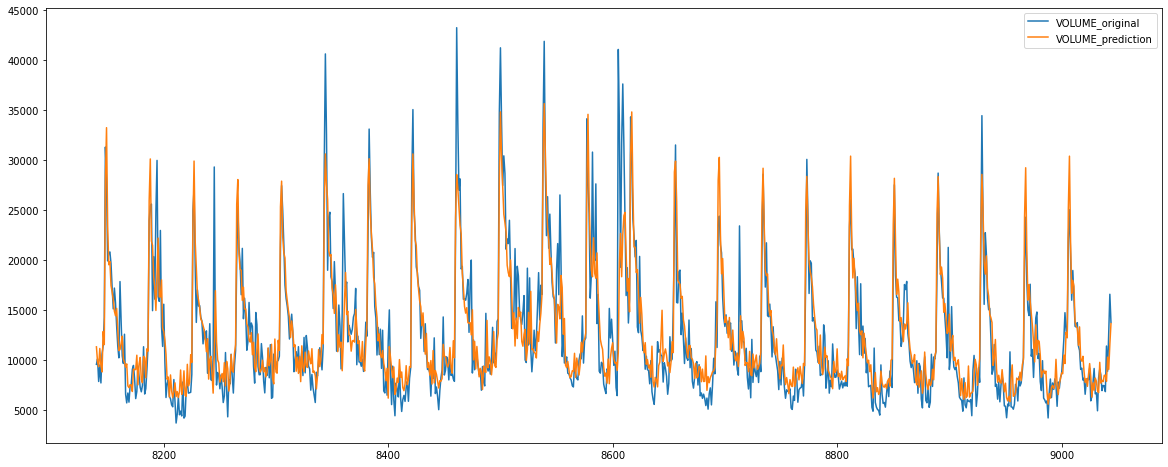

In [104]:
prediction_dnn = pd.DataFrame(
    pd.concat([pd.DataFrame(dnn.predict(x_test), index=x_test.index) for dnn in dnn_models], axis=1).mean(axis=1),
    columns=['prediction'])

tdf_test = prediction_dnn.join(df)[['prediction', 'VOLUME_fut_agg', 'VOLUME_fut_orig']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_orig']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_dnn = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_dnn = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_dnn = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_dnn / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_dnn, mae_dnn, mape_dnn)

<AxesSubplot:>

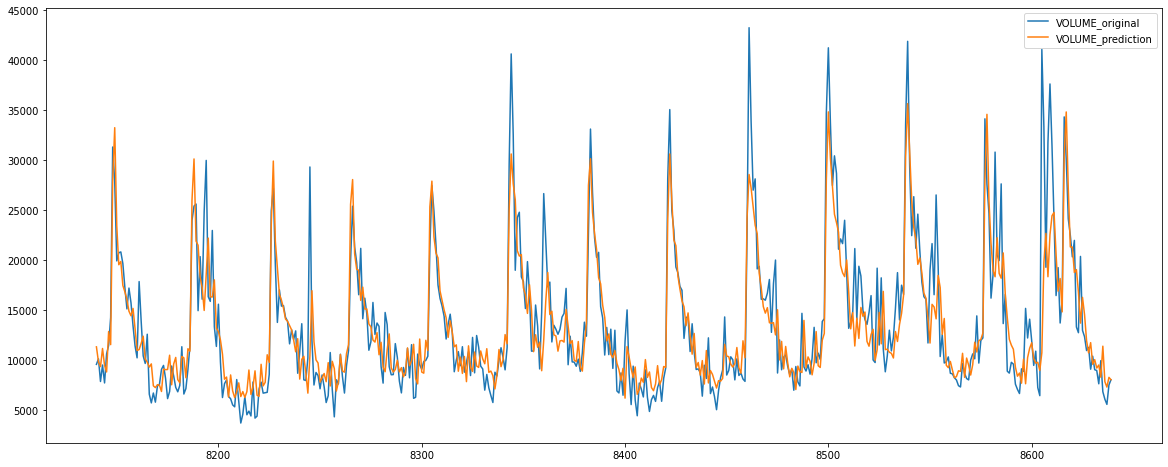

In [105]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

## Deep Forest (Cascade Forest)

In [106]:
# ccd = CascadeForestRegressor(n_jobs=8, n_estimators=3, n_trees=300, max_layers=15)
# ccd.fit(pd.concat([x_train, x_val]).values, np.ravel(pd.concat([y_train, y_val]).values))

iters = 1
param_grid = {'n_estimators': [3], 'n_trees': [300], 'max_layers': [5]}
for params in ParameterGrid(param_grid):
    r2_ccd, mae_ccd, mape_ccd = 0, 0, 0
    for j in range(iters):
        ccd = CascadeForestRegressor(n_jobs=8, n_estimators=params['n_estimators'], n_trees=params['n_trees'],
                                     max_layers=params['max_layers'], random_state=0, verbose=0)
        ccd.fit(x_train.values, np.ravel(y_train.values))

        prediction_ccd = pd.DataFrame(ccd.predict(x_val), index=x_val.index, columns=['prediction'])

        tdf_val = prediction_ccd.join(df)[['prediction', 'VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
        tdf_val['VOLUME_prediction'] = tdf_val['prediction'] + tdf_val['VOLUME_fut_agg']
        tdf_val['VOLUME_original'] = tdf_val['VOLUME_fut'] + tdf_val['VOLUME_fut_agg']

        r2_ccd += r2_score(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])
        mae_ccd += mean_absolute_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])
        mape_ccd += mean_absolute_percentage_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])

    r2_ccd /= iters
    mae_ccd /= iters
    mape_ccd /= iters
    print(params)
    print('R2, MAE, MAPE:')
    print(r2_ccd, mae_ccd, mape_ccd)

{'max_layers': 5, 'n_estimators': 3, 'n_trees': 300}
R2, MAE, MAPE:
0.7672973718878513 2321.344225664011 0.19258771816978282


MAE/StdDev 33.325379138141045
R2, MAE, MAPE:
0.7661898952136535 2199.503148057308 0.18920145845650518


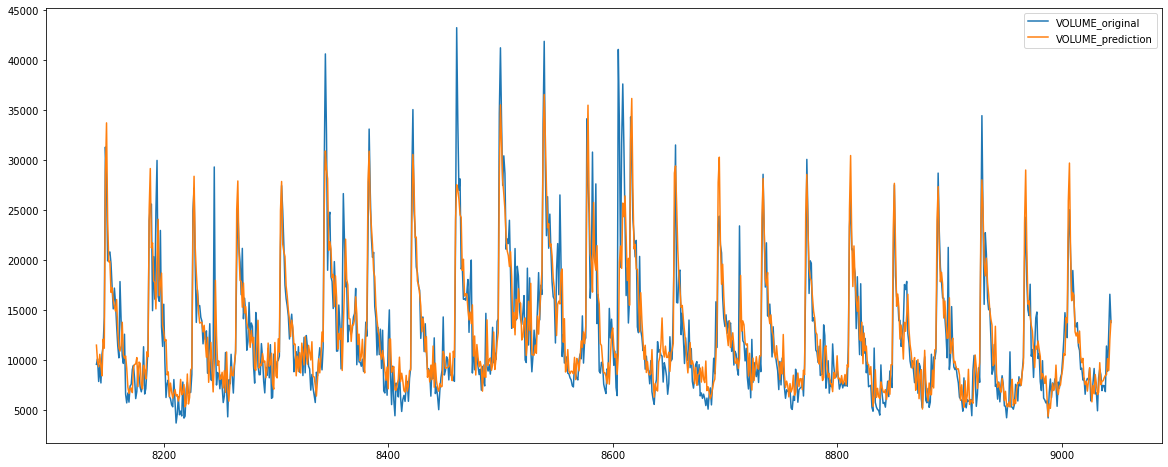

In [107]:
prediction_ccd = pd.DataFrame(ccd.predict(x_test), index=x_test.index, columns=['prediction'])

tdf_test = prediction_ccd.join(df)[['prediction', 'VOLUME_fut_agg', 'VOLUME_fut_orig']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut_orig']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_ccd = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_ccd = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_ccd = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_ccd / std_orig * 100)
print('R2, MAE, MAPE:')
print(r2_ccd, mae_ccd, mape_ccd)

## Totals

In [108]:
print('Baseline:', r2_baseline, mae_baseline, mape_baseline)
print('XGBoost:', r2_xgb, mae_xgb, mape_xgb)
print('CatBoost:', r2_cat, mae_cat, mape_cat)
print('DNN:', r2_dnn, mae_dnn, mape_dnn)
print('Cascade Forest:', r2_ccd, mae_ccd, mape_ccd)

Baseline: 0.693874749196424 2517.9539121861744 0.21110923894757902
XGBoost: 0.7701811332770669 2165.816664522895 0.18454368804959367
CatBoost: 0.7609025722783413 2128.382742759838 0.17338454665249972
DNN: 0.7661083822240289 2207.869803363762 0.19379979414581647
Cascade Forest: 0.7661898952136535 2199.503148057308 0.18920145845650518
